# Optimización industrial con Computación Evolutiva 
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)
Dra. Soledad Espezua Llerena (sespezua@pucp.edu.pe )


## Neuroevolucion con Topologia Fija: Entorno de Cart-Pole

In [1]:
import gym
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from statistics import median, mean
from collections import Counter
from copy import deepcopy
from keras.models import Sequential # cria uma pilha de camadas de redes neurais
from keras.layers import Dense, Activation

Using TensorFlow backend.


### Funciones que implementan un AG para evoluir los pesos de una red neuronal que controla el Cart-Pole

La función del AG es encontrar pesos optimos para la Red Neuronal mostrada abajo para que equilibren el pendulo en el carrito. Un individuo es una Red Neuronal con pesos específicos. La funcion de fitness (reward en el caso de Aprendizaje por refuerzo) será el promedio del numero de time-steps que la red neuronal consiga mantener al pendulo en equilibrio en (promedio de 10 intentos)

<img src="https://vtoliveira.github.io/assets/images/nn.jpg">  

Imagen fuente: https://github.com/vtoliveira/Neuroevolucao-CartPole-OpenGymAI

### Define la estructura de un individuo en el AG con sus operadores genéticos 

In [2]:
class Individual:
    """ Un individuo es una red neuronal feed-forward con topologia pre-especificada [INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM].
       se le puede pasar pesos iniciales en el constructor. Si no se pasa pesos se asume pesos aleatorios  """

    def __init__(self, input_dim, hidden_dim, output_dim, weights='random'):  # constructor recibe dimensiones de la red y pesos
        self.model = Sequential()
        self.model.add(Dense(units=hidden_dim, input_dim=input_dim))
        self.model.add(Activation("relu"))
        self.model.add(Dense(units=output_dim))
        self.model.add(Activation("softmax"))
        
        if weights != 'random':   # si se han pasado pesos, entonces se setea esos pesos en la red neuronal
            self.model.set_weights(weights)
        
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado aun

    def crossover(self, other):
        "Retorna dos nuevos individuos del cruzamiento de self y other "
        w_self  = self.model.get_weights()
        w_other = other.model.get_weights()
        
        for _ in range(4):   # repite 4 veces el intercambio de pesos
            cx_array = random.sample([0,1,2,3], 1)[0]   # escoge uno de los 4 arrays de pesos para cruzar
            
            if cx_array == 0 or cx_array == 2: # crossover ocurrirá en las matrizes de pesos (matrices de 4x4)
                cx_row = random.sample([0,1,2,3], 1)[0] # escoge la fila de la matriz de pesos a intercambiar
                # print ("WEIGHTS CX, cx_array={}, cx_row={}".format(cx_array, cx_row))
                # Intercambia las filas escogidas de la matriz de pesos
                row_self = deepcopy( w_self[cx_array][cx_row] )
                w_self[cx_array][cx_row] =  deepcopy( w_other[cx_array][cx_row] )
                w_other[cx_array][cx_row] = row_self

            else: # crossover ocurrirá en los vectores de bias (vectores de 1x4)
                # print ("BIAS CX,  cx_array={}".format(cx_array))
                row_self = deepcopy( w_self[cx_array] )
                w_self[cx_array] =  deepcopy( w_other[cx_array] )
                w_other[cx_array] = row_self        
            
        ind1 = Individual(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, w_self)
        ind2 = Individual(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, w_other)
        return [ind1, ind2]   
    

    def mutate(self):
        "Realiza mutacion en un vector de pesos"
        mx_array = random.sample([0,1,2,3], 1)[0]   # escoge uno de los 4 arrays de pesos para mutar
        mx_delta = random.uniform(-0.50,0.50)   # escoge un valor aleatorio con el que se alterará los pesos escogidos 
        w_self  = self.model.get_weights()   # obtiene los pesos de self
        
        if mx_array == 0 or mx_array == 2: # mutacion ocurrirá en alguna de las matrizes de pesos (matrices de 4x4)
            mx_row = random.sample([0,1,2,3], 1)[0]   # escoge la fila de la matriz de pesos a mutar
            w_self[mx_array][mx_row] += mx_delta      # muta
            # print ("WEIGHTS MX, cx_array={}, mx_row={}".format(mx_array, mx_row))
            
        else:   # mutacion ocurrirá en un vector de Bias
            w_self[mx_array] += mx_delta      # muta
            # print ("BIAS MX,  mx_array={}".format(mx_array))
            
        self.model.set_weights(w_self)
  

### Funcion para inicializar una población de individuos (redes neuronales)

In [3]:
def init_population(pop_size, input_dim, hidden_dim, output_dim):
    """Inicializa una poblacion de pop_size individuos, 
       Cada individuo tiene la misma topologia de red neuronal y pesos aleatorios"""
    population = []
    for i in range(pop_size):
        population.append( Individual(input_dim, hidden_dim, output_dim) )
        
    return population

### Funcion para obtener el fitness de un individuo (red neuronal) en el entorno

In [4]:
def get_fitness(ind, env, env_trials, env_frames ):
    """Retorna el fitness de un individuo (red neuronal) en el entorno pasado (env). 
       El fitness es la media del score del individuo obtenido en env_trials corridas del entorno
       Cada trial se ejecuta con un máximo de env_frames pasos """

    current_state = []
    scores = []
    
    for _ in range(env_trials):  # ejecuta env_trials  corridas del entorno
        env.reset()  # reinicializa el entorno
        score = 0
        for _ in range(env_frames):  # en cada trial ejecuta env_frames  pasos
            if len(current_state) == 0:    # si es el primer movimiento  -> escoge una accion aleatoria
                action = random.randrange(0,2)
            else:
                action = np.argmax( ind.model.predict(current_state.reshape(1, 4)) ) # infiere la accion con la red neuronal

            new_state, reward, done, info = env.step(action)  # corre el entorno un step ejecutando la accion inferida
            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            current_state = new_state
            if done: break   # si es estado terminal termina el trial
        scores.append(score)
    
    return sum(scores) /float(env_trials)    # retorna la media de los scores de todas las corridas

### Funcion para evaluar una población de individuos 

In [5]:
def evaluate_population(population, env, env_trials, env_frames ):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:    # si el individuo no esta evaluado entonces lo evalua
            population[i].fitness = get_fitness(population[i], env, env_trials, env_frames)

### Funcion que escoge una pareja de individuos para cruzamiento  (metodo de ruleta)

In [6]:
def select_parents_roulette(population):
    pop_size = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

### Funcion que selecciona la poblacion de la sgte generacion, dada la poblacion actual y poblacion de hijos

In [7]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico para encontrar Individuos (redes neuronales de topologia fija) capaces de jugar CartPool


In [8]:
def genetic_algorithm(population, env, env_trials, env_frames, ngen=100, pmut=0.1):
    """Algoritmo Genetico para el problema de la mochila
        population:  Poblacion inicial de individuos (de la clase Individual)
        env:        Entorno donde actuaran los individuos
        env_trials: numero de corridas del entorno para evaluar un individuo
        env_frames: maximo numero de pasos en cada corrida del entorno 
        ngen:       maximo numero de generaciones 
        pmut:       taza de mutacion
    """
    
    pop_size = len(population)
    evaluate_population(population, env, env_trials, env_frames) # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(pop_size/2)): mating_pool.append(select_parents_roulette(population)) 
        
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            offspring_population.extend( mating_pool[i][0].crossover(mating_pool[i][1]) ) # cruzamiento 

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                    offspring_population[i].mutate() 
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, env, env_trials, env_frames)   # evalua la poblacion descendencia
        
        ## Selecciona pop_size individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, pop_size)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        
        print("generacion {}, Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Fitness de mejor individuo en ultima generacion = {})".format(population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

### Prueba La neuroevolucion en busca de una Inteligencia capaz de jugar CartPool


In [9]:
## Hiperparametros de los modelos neuronales
INPUT_DIM = 4   # numero de entradas de la Red Neuronal (= numero de features del estado)
HIDDEN_DIM = 4  # numero de neuronas ocultas
OUTPUT_DIM = 2  # numero de neuronas de dalida (= numero de acciones)

In [10]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 10       # numero de individuos
GENERATIONS = 15   # numero de generaciones
TRIALS_ENV = 5    # numero de corridas del entorno  para evaluar un individuo
FRAMES_ENV = 400   # numero de time steps para evaluar una corrida del entorno
PMUT = 0.3         # taza de mutacion

Instructions for updating:
Colocations handled automatically by placer.
Poblacion inicial, best_fitness = 301.4
generacion 0, Mejor fitness = 355.6)
generacion 1, Mejor fitness = 396.0)
generacion 2, Mejor fitness = 400.0)
generacion 3, Mejor fitness = 400.0)
generacion 4, Mejor fitness = 400.0)
generacion 5, Mejor fitness = 400.0)
generacion 6, Mejor fitness = 400.0)
generacion 7, Mejor fitness = 400.0)
generacion 8, Mejor fitness = 400.0)
generacion 9, Mejor fitness = 400.0)
generacion 10, Mejor fitness = 400.0)
generacion 11, Mejor fitness = 400.0)
generacion 12, Mejor fitness = 400.0)
generacion 13, Mejor fitness = 400.0)
generacion 14, Mejor fitness = 400.0)
Fitness de mejor individuo en ultima generacion = 400.0)


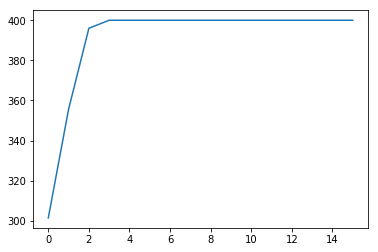

In [11]:
# carga el entorno Cartpole de gym
env = gym.make('CartPole-v1')  

## Inicializa una poblacion inicial de forma aleatoria
population = init_population(POP_SIZE, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)

# realiza la neuroevolucion con el algoritmo genetico 
best_ind, bestfitness = genetic_algorithm(population, env, TRIALS_ENV, FRAMES_ENV, GENERATIONS, PMUT)

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

In [12]:
def play_CartPole(ind, trials = 1):
    env = gym.make('CartPole-v1')  
    scores = []
    for each_game in range(trials):
        score = 0
        game_memory = []
        current_state = []
        env.reset()
        for _ in range(500): # en cada trial ejecuta 500  pasos
            env.render()

            if len(current_state) == 0:    # si es el primer movimiento  -> escoge una accion aleatoria
                action = random.randrange(0,2)
            else:
                action = np.argmax( ind.model.predict(current_state.reshape(1, 4)) ) # infiere la accion con la red neuronal

            new_state, reward, done, info = env.step(action)  # corre el entorno un step ejecutando la accion inferida
            score += reward   # acumula el reward (reward=1 en cualquier estado no terminal)
            current_state = new_state
            game_memory.append([new_state, action])
            if done: break
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )
    
    

In [13]:
play_CartPole(best_ind,5)

Score medio = 500.0
